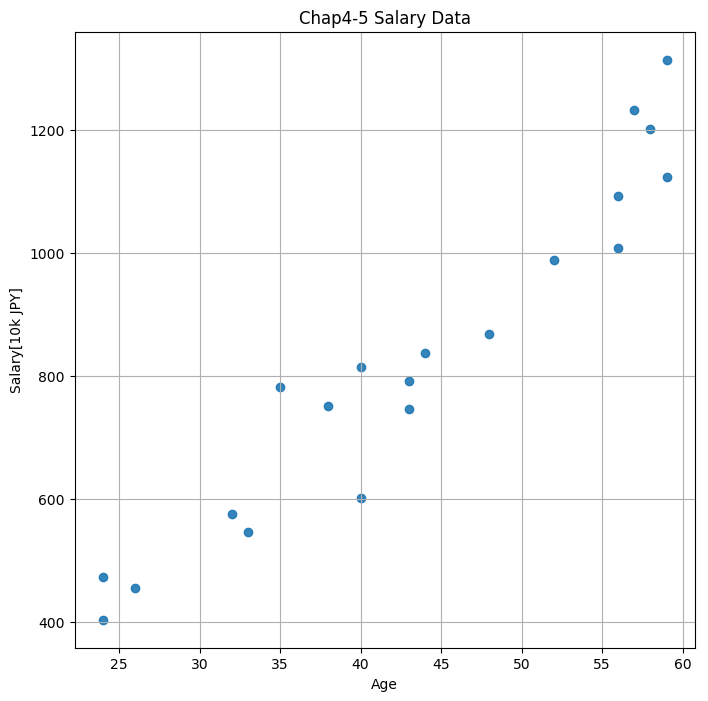

In [1]:
using Distributions
using StatsBase
using PyPlot

# アヒル本4章のデータ
x=Real[ 24, 24, 26, 32, 33, 35, 38, 40, 40, 43, 43, 44, 48, 52,  56,  56,  57,  58,  59,  59]
y=Real[472,403,454,575,546,781,750,601,814,792,745,837,868,988,1092,1007,1233,1202,1123,1314]

# Plot
fig = figure(figsize=(8,8));ax = axes()
scatter(x, y,alpha=0.9)

title("Chap4-5 Salary Data")
xlabel("Age")
ylabel("Salary[10k JPY]")
grid("on")

In [2]:
function likelihood(a, b, sigma)
    y_pred = a + b*x
    likehoods = [logpdf(Normal(aa, sigma), bb) for (aa,bb) in zip(y_pred,y)]
    l_sum = sum(likehoods)
    return l_sum
end

function prior(a, b, sigma)
    a_prior     = logpdf(Normal(0, 100),a)
    b_prior     = logpdf(Normal(0, 100),b)
    sigma_prior = logpdf(Uniform(0,1000),sigma)
    return a_prior + b_prior + sigma_prior
end

function posterior(a, b, sigma)
    return(likelihood(a, b, sigma) + prior(a, b, sigma))
end

function proposal(a, b, sigma, SIGMA)
    return [rand(Normal(mu, sd)) for (mu, sd) in zip([a, b, sigma],SIGMA)]
end

proposal (generic function with 1 method)

In [3]:
function MCMC(SIGMA)
    #MH法
    # a, b, sigmaの初期値; Chain 1つ分
    Init = Real[-120, 22, 70]
    push!(Init,likelihood(Init[1],Init[2],Init[3]))
    Iteration = 20000
    BurnIn    =  5000
    chain = Array[Init]

    acceptance = 0

    for i in 1:Iteration
        proposal_draw   = proposal(chain[i][1], chain[i][2], chain[i][3],SIGMA)

        tmp1 = posterior(proposal_draw[1],proposal_draw[2],proposal_draw[3])
        tmp2 = posterior(chain[i][1], chain[i][2], chain[i][3])
        alpha = min(1,exp(tmp1-tmp2))

        u = rand(Uniform(0,1))

        if u < alpha
            push!(chain,proposal_draw)
            acceptance += 1
        else
            push!(chain,chain[i])
        end
    end

    # BurnInは除外
    chain = chain[BurnIn+1:end]

    # 結果の取り出し
    a = [chain[i][1] for i in 1:length(chain)]
    b = [chain[i][2] for i in 1:length(chain)]
    sigma = [chain[i][3] for i in 1:length(chain)]

    println("MCMC complete")
    return (a, b, sigma, acceptance/(Iteration-BurnIn))
end

MCMC (generic function with 1 method)

MCMC complete
MCMC complete


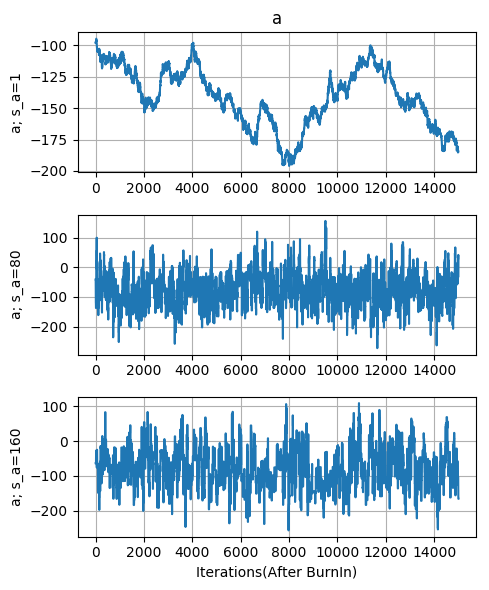

MCMC complete


In [4]:
a1,_,_,ac = MCMC([1,1,8])
a80,_,_,ac80 = MCMC([80,1,8])
a160,_,_,ac160 = MCMC([160,1,8])

# Plot 
fig = figure(figsize=(5,6))
ax = fig[:add_subplot](3,1,1)
plot(a1)
ylabel("a; s_a=1")
title("a")
grid("on")

ax = fig[:add_subplot](3,1,2)
plot(a80)
ylabel("a; s_a=80")
grid("on")

ax = fig[:add_subplot](3,1,3)
plot(a160)
xlabel("Iterations(After BurnIn)")
ylabel("a; s_a=160")
grid("on")

tight_layout()

In [5]:
[[autocor(a1,[1]),autocor(a80,[1]),autocor(a160,[1])]
 [ac,ac80,ac160]]

6-element Array{Any,1}:
  [0.999408]
  [0.94333] 
  [0.959759]
 0.510533   
 0.267333   
 0.160333   

In [6]:
a,b,sigma,acceptance = MCMC([80,1,8])

MCMC complete


([-140.057, -140.057, -140.057, -140.057, -140.057, -140.057, -44.8393, -44.8393, -44.8393, -44.8393  …  -10.0328, -10.0328, -10.0328, -10.0328, -10.0328, -10.0328, -10.0328, -67.2751, -67.2751, -106.423], [22.108, 22.108, 22.108, 22.108, 22.108, 22.108, 19.9977, 19.9977, 19.9977, 19.9977  …  19.67, 19.67, 19.67, 19.67, 19.67, 19.67, 19.67, 21.5181, 21.5181, 21.5597], [60.1972, 60.1972, 60.1972, 60.1972, 60.1972, 60.1972, 61.7821, 61.7821, 61.7821, 61.7821  …  105.573, 105.573, 105.573, 105.573, 105.573, 105.573, 105.573, 103.11, 103.11, 92.9055], 0.2704)

In [7]:
[autocor(a,[1]), autocor(b,[1]),autocor(sigma,[1])]

3-element Array{Array{Float64,1},1}:
 [0.948694]
 [0.961165]
 [0.973524]

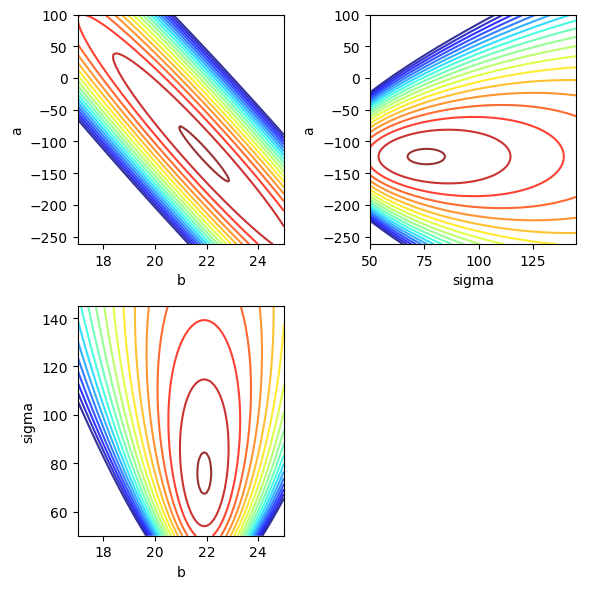

In [8]:
_a = -120.0
_b = 22.0
_sigma = 79.0

a_list = collect(-262:100)
b_list = collect(17:0.1:25)
sigma_list = collect(50:145)

ab_list = [likelihood(tmp_a,tmp_b,_sigma) for tmp_a in a_list, tmp_b in b_list]
ac_list = [likelihood(tmp_a,_b,    tmp_sigma) for tmp_a in a_list, tmp_sigma in sigma_list]
cb_list = [likelihood(_a, tmp_b,tmp_sigma) for tmp_sigma in sigma_list, tmp_b in b_list]

levels = collect(-160:2.5:-115)

# Plot 
fig = figure(figsize=(6,6))

ax = fig[:add_subplot](2,2,1)
b_grid = repmat(b_list',length(a_list),1)
a_grid = repmat(a_list, 1, length(b_list))
cp = ax[:contour](b_grid,a_grid, ab_list, levels=levels, linewidth=1.0, cmap="jet",alpha=0.8)
xlabel("b")
ylabel("a")

subplot(222)
ax = fig[:add_subplot](2,2,2)
c_grid = repmat(sigma_list',length(a_list),1)
a_grid = repmat(a_list, 1, length(sigma_list))
cp = ax[:contour](c_grid,a_grid, ac_list, levels=levels, linewidth=1.0, cmap="jet",alpha=0.8)
xlabel("sigma")
ylabel("a")

subplot(223)
ax = fig[:add_subplot](2,2,3)
b_grid = repmat(b_list',length(sigma_list),1)
c_grid = repmat(sigma_list, 1, length(b_list))
cp = ax[:contour](b_grid,c_grid, cb_list, levels=levels, linewidth=1.0, cmap="jet",alpha=0.8)
xlabel("b")
ylabel("sigma")

tight_layout()

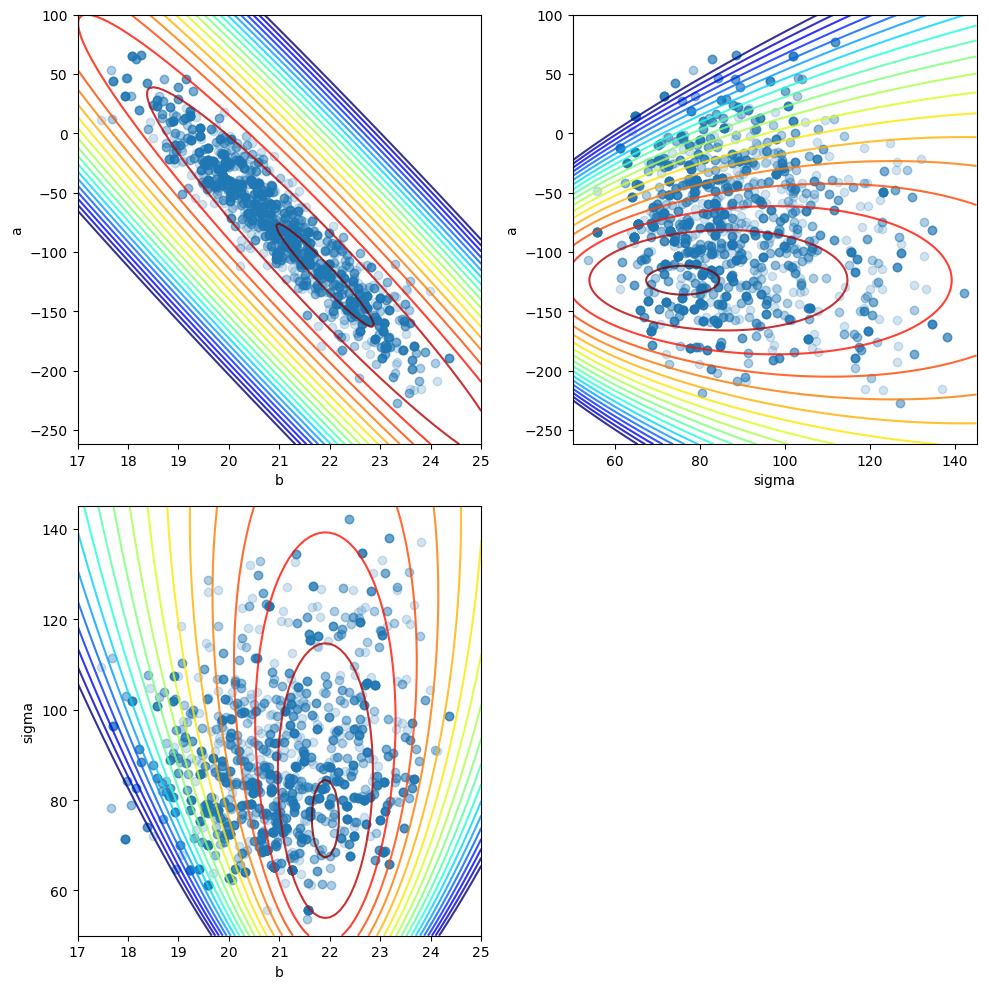

MCMC complete


In [10]:
a,b,sigma,acceptance = MCMC([60,1,8])

_a = -120.0
_b = 22.0
_sigma = 79.0

a_list = collect(-262:100)
b_list = collect(17:0.1:25)
sigma_list = collect(50:145)

ab_list = [likelihood(tmp_a,tmp_b,_sigma) for tmp_a in a_list, tmp_b in b_list]
ac_list = [likelihood(tmp_a,_b,    tmp_sigma) for tmp_a in a_list, tmp_sigma in sigma_list]
cb_list = [likelihood(_a, tmp_b,tmp_sigma) for tmp_sigma in sigma_list, tmp_b in b_list]

levels = collect(-160:2.5:-115)

# 結果の取り出し
sample_size = length(a)-3000:length(a)

a = a[sample_size]
b = b[sample_size]
sigma = sigma[sample_size]

# Plot 
fig = figure(figsize=(10,10))
ax = fig[:add_subplot](2,2,1)

b_grid = repmat(b_list',length(a_list),1)
a_grid = repmat(a_list, 1, length(b_list))

cp = ax[:contour](b_grid,a_grid, ab_list, levels=levels, linewidth=2.0, cmap="jet",alpha=0.8)
scatter(b,a,alpha=0.2)
xlabel("b")
ylabel("a")
ax[:set_xlim]([b_list[1],b_list[end]])
ax[:set_ylim]([a_list[1],a_list[end]])

subplot(222)
ax = fig[:add_subplot](2,2,2)

c_grid = repmat(sigma_list',length(a_list),1)
a_grid = repmat(a_list, 1, length(sigma_list))

cp = ax[:contour](c_grid,a_grid, ac_list, levels=levels, linewidth=2.0, cmap="jet",alpha=0.8)
scatter(sigma,a,alpha=0.2)
xlabel("sigma")
ylabel("a")
ax[:set_xlim]([sigma_list[1],sigma_list[end]])
ax[:set_ylim]([a_list[1],a_list[end]])

subplot(223)
ax = fig[:add_subplot](2,2,3)

b_grid = repmat(b_list',length(sigma_list),1)
c_grid = repmat(sigma_list, 1, length(b_list))

cp = ax[:contour](b_grid,c_grid, cb_list, levels=levels, linewidth=2.0, cmap="jet",alpha=0.8)
scatter(b,sigma,alpha=0.2)
xlabel("b")
ylabel("sigma")
ax[:set_xlim]([b_list[1],b_list[end]])
ax[:set_ylim]([sigma_list[1],sigma_list[end]])
tight_layout()